$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 5: Convolutional Architecture Experiments
<a id=part5></a>

In this part we will explore convolution networks and the effects of their architecture on accuracy. We'll use our deep CNN implementation and perform various experiments on it while varying the architecture. Then we'll implement our own custom architecture to see whether we can get high classification results on a large subset of CIFAR-10.

Training will be performed on GPU.

In [1]:
import os
import re
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import unittest
import torch
import torchvision
import torchvision.transforms as tvtf

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
seed = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.rcParams.update({'font.size': 12})
test = unittest.TestCase()

## Experimenting with model architectures
<a id=part5_3></a>

We will now perform a series of experiments that train various model configurations on a part of the CIFAR-10 dataset.

To perform the experiments, you'll need to use a machine with a GPU since training time might be too long otherwise.


### Note about running on GPUs

Here's an example of running a forward pass on the GPU
(assuming you're running this notebook on a GPU-enabled machine).

In [3]:
from hw2.cnn import ResNet

net = ResNet(
    in_size=(3,100,100), out_classes=10, channels=[32, 64]*3,
    pool_every=4, hidden_dims=[100]*2,
    pooling_type='avg', pooling_params=dict(kernel_size=2),
)
net = net.to(device)

test_image = torch.randint(low=0, high=256, size=(3, 100, 100), dtype=torch.float).unsqueeze(0)
test_image = test_image.to(device)

test_out = net(test_image)

Notice how we called `.to(device)` on **both** the model and the input tensor.
Here the `device` is a `torch.device` object that we created above. If an nvidia GPU is available on the machine you're running this on, the `device` will be `'cuda'`. When you run `.to(device)` on a model, it recursively goes over all the model parameter tensors and copies their memory to the GPU. Similarly, calling `.to(device)` on the input image also copies it.

In order to train on a GPU, you need to make sure to move **all** your tensors to it. You'll get errors if you try to mix CPU and GPU tensors in a computation.

In [4]:
print(f'This notebook is running with device={device}')
print(f'The model parameter tensors are also on device={next(net.parameters()).device}')
print(f'The test image is also on device={test_image.device}')
print(f'The output is therefore also on device={test_out.device}')

This notebook is running with device=cuda
The model parameter tensors are also on device=cuda:0
The test image is also on device=cuda:0
The output is therefore also on device=cuda:0


### Notes on using course servers

First, please read the [course servers guide](https://vistalab-technion.github.io/cs236781/assignments/hpc-servers) carefully.

To run the experiments on the course servers, you can use the `py-sbatch.sh` script directly to perform a single experiment run in batch mode (since it runs python once), or use the `srun` command to do a single run in interactive mode. For example, running a single run of experiment 1 interactively (after `conda activate` of course):

```shell
srun -c 2 --gres=gpu:1 --pty python -m hw2.experiments run-exp -n test -K 32 64 -L 2 -P 2 -H 100
```

To perform multiple runs in batch mode with `sbatch` (e.g. for running all the configurations of an experiments), you can create your own script based on `py-sbatch.sh` and invoke whatever commands you need within it.

Don't request more than **2 CPU** cores and **1 GPU** device for your runs. The code won't be able to utilize more than that anyway, so you'll see no performance gain if you do. It will only cause delays for other students using the servers.

### General notes for running experiments

- You can run the experiments on a different machine (e.g. the course servers) and copy the results (files)
  to the `results` folder on your local machine.
  This notebook will only display the results, not run the actual experiment code (except for a demo run).
- It's important to give each experiment run a name as specified by the notebook instructions later on.
  Each run has a `run_name` parameter that will also be the base name of the results file which this 
  notebook will expect to load.
- You will implement the code to run the experiments in the `hw2/experiments.py` module.
  This module has a CLI parser so that you can invoke it as a script and pass in all the
  configuration parameters for a single experiment run.
- You should use `python -m hw2.experiments run-exp` to run an experiment, and **not**
  `python hw2/experiments.py run-exp`, regardless of how/where you run it.

### Experiment 1: Network depth and number of filters

In this part we will test some different architecture configurations based on our `CNN` and `ResNet`.
Specifically, we want to try different depths and number of features to see the effects these parameters have on the model's performance.

To do this, we'll define two extra hyperparameters for our model, `K` (`filters_per_layer`) and `L` (`layers_per_block`).
- `K` is a list, containing the number of filters we want to have in our conv layers.
- `L` is the number of consecutive layers with the same number of filters to use.

For example, if `K=[32, 64]` and `L=2` it means we want two conv layers with 32 filters followed by two conv layers with 64 filters. If we also use `pool_every=3`, the feature-extraction part of our model will be:

    Conv(X,32)->ReLu->Conv(32,32)->ReLU->Conv(32,64)->ReLU->MaxPool->Conv(64,64)->ReLU
    
We'll try various values of the `K` and `L` parameters in combination and see how each architecture trains. **All other hyperparameters are up to you**, including the choice of the optimization algorithm, the learning rate, regularization and architecture hyperparams such as `pool_every` and `hidden_dims`. Note that you should select the `pool_every` parameter wisely per experiment so that you don't end up with zero-width feature maps.

You can try some short manual runs to determine some good values for the hyperparameters or implement cross-validation to do it. However, the **dataset size** you test on should be large. If you limit the number of batches, make sure to use at least 30000 training images and 5000 validation images.

The important thing is that you state what you used, how you decided on it, and explain your results based on that.

First we need to write some code to run the experiment.

**TODO**:
1. Implement the `cnn_experiment()` function in the `hw2/experiments.py` module.
1. If you haven't done so already, it would be an excellent idea to implement the **early stopping** feature of the `Trainer` class.

The following block tests that your implementation works. It's also meant to show you that each experiment run creates a result file containing the parameters to reproduce and the `FitResult` object for plotting.

Files already downloaded and verified


Files already downloaded and verified


--- EPOCH 1/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 2/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 3/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 4/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 5/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 6/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 7/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 8/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 9/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 10/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

*** Output file ./results/test_run_L1_K32-64.json written
experiment config:  {'run_name': 'test_run', 'out_dir': './results', 'seed': 42, 'device': None, 'bs_train': 50, 'bs_test': 12, 'batches': 10, 'epochs': 10, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'filters_per_layer': [32, 64], 'pool_every': 1, 'hidden_dims': [100], 'model_type': 'resnet', 'conv_params': {'kernel_size': 3, 'stride': 1, 'padding': 1}, 'activation_type': 'relu', 'activation_params': {}, 'pooling_type': 'max', 'pooling_params': {'kernel_size': 2}, 'batchnorm': True, 'dropout': 0.2, 'bottleneck': False, 'kw': {}, 'layers_per_block': 1}


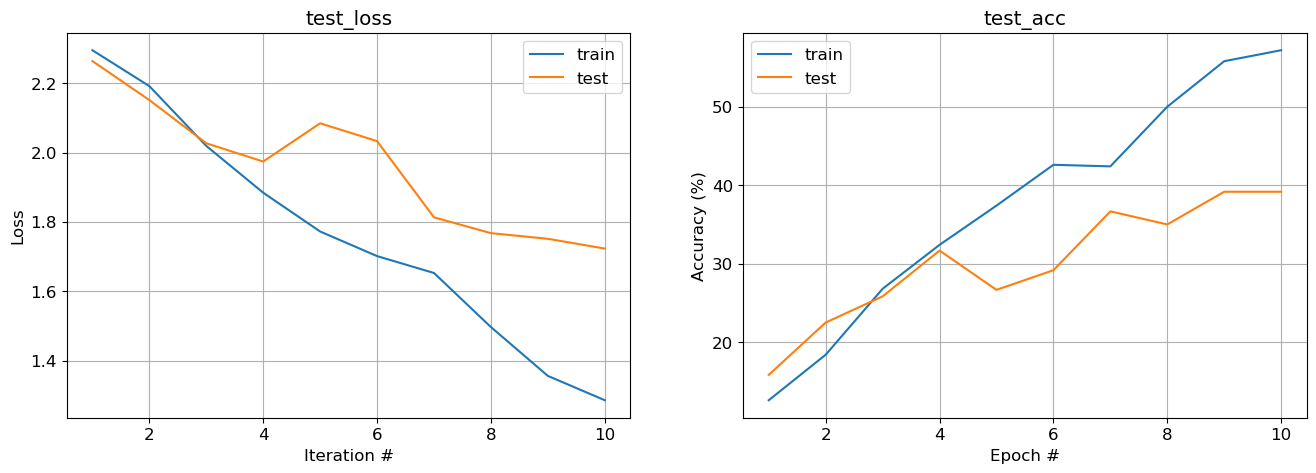

In [5]:
from hw2.experiments import load_experiment, cnn_experiment
from cs236781.plot import plot_fit

# Test experiment1 implementation on a few data samples and with a small model
cnn_experiment(
    'test_run', seed=seed, bs_train=50, batches=10, epochs=10, early_stopping=5,
    filters_per_layer=[32,64], layers_per_block=1, pool_every=1, hidden_dims=[100],
    model_type='resnet',
)

# There should now be a file 'test_run.json' in your `results/` folder.
# We can use it to load the results of the experiment.
cfg, fit_res = load_experiment('results/test_run_L1_K32-64.json')
_, _ = plot_fit(fit_res, train_test_overlay=True)

# And `cfg` contains the exact parameters to reproduce it
print('experiment config: ', cfg)

In [6]:
def plot_exp_results(filename_pattern, results_dir='results'):
    fig = None
    result_files = glob.glob(os.path.join(results_dir, filename_pattern))
    result_files.sort()
    if len(result_files) == 0:
        print(f'No results found for pattern {filename_pattern}.', file=sys.stderr)
        return
    for filepath in result_files:
        m = re.match('exp\d_(\d_)?(.*)\.json', os.path.basename(filepath))
        cfg, fit_res = load_experiment(filepath)
        fig, axes = plot_fit(fit_res, fig, legend=m[2],log_loss=True)
    del cfg['filters_per_layer']
    del cfg['layers_per_block']
    print('common config: ', cfg)

#### Experiment 1.1: Varying the network depth (`L`)

First, we'll test the effect of the network depth on training.

**Configuratons**:
- `K=32` fixed, with `L=2,4,8,16` varying per run
- `K=64` fixed, with `L=2,4,8,16` varying per run

So 8 different runs in total.

**Naming runs**:
Each run should be named `exp1_1_L{}_K{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_1_L2_K32`. 

**TODO**: Run the experiment on the above configuration with the `CNN` model. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_1', 'out_dir': '/home/galkesten/CS236781/Homework2/results', 'seed': 42, 'device': None, 'bs_train': 32, 'bs_test': 32, 'batches': 1500, 'epochs': 30, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.0001, 'reg': 0.0001, 'pool_every': 4, 'hidden_dims': [128], 'model_type': 'cnn', 'conv_params': {'kernel_size': 3, 'stride': 1, 'padding': 1}, 'activation_type': 'relu', 'activation_params': {}, 'pooling_type': 'max', 'pooling_params': {'kernel_size': 2}, 'batchnorm': False, 'dropout': 0.0, 'bottleneck': False, 'kw': {}}


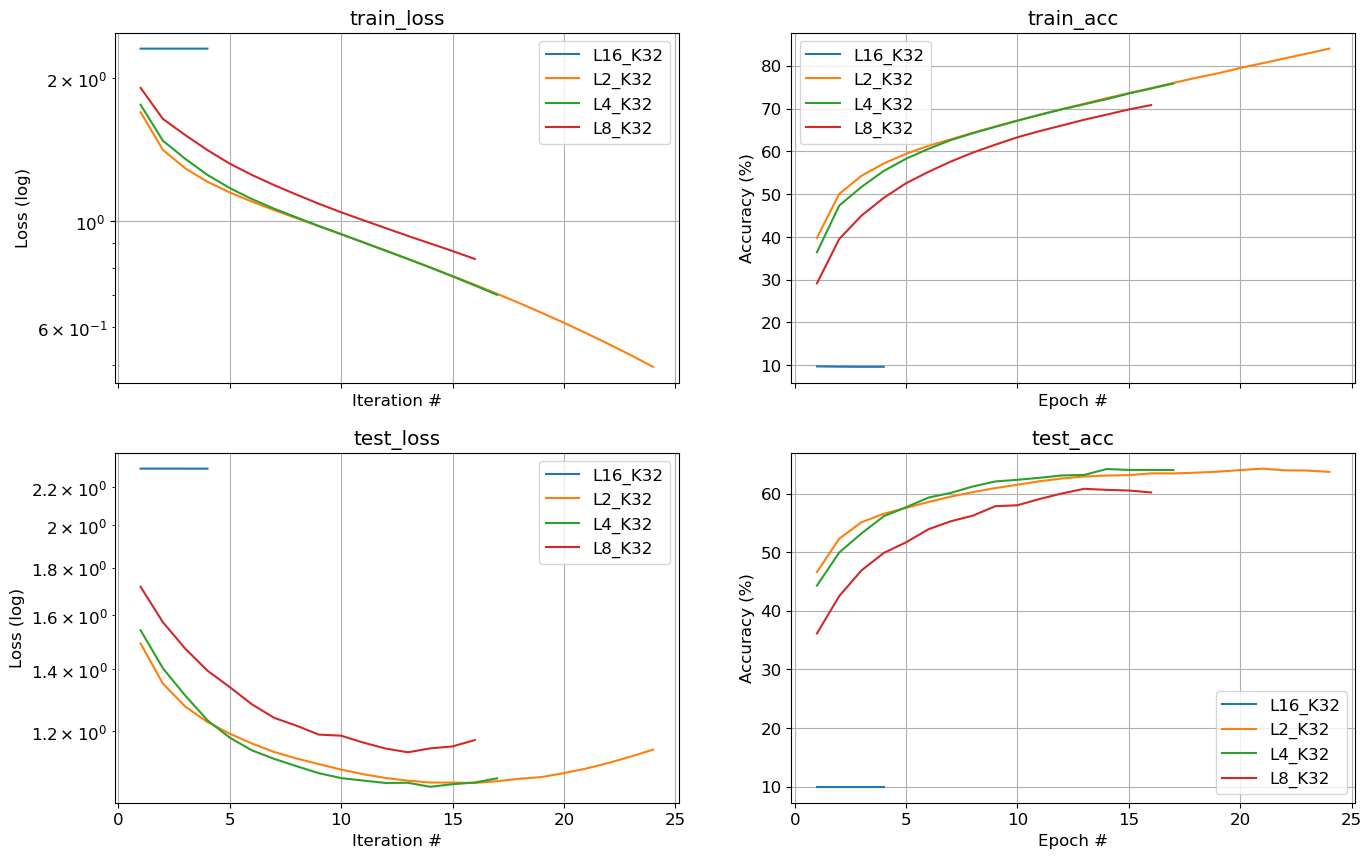

In [7]:
plot_exp_results('exp1_1_L*_K32*.json')

common config:  {'run_name': 'exp1_1', 'out_dir': '/home/galkesten/CS236781/Homework2/results', 'seed': 42, 'device': None, 'bs_train': 32, 'bs_test': 32, 'batches': 1500, 'epochs': 30, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.0001, 'reg': 0.0001, 'pool_every': 4, 'hidden_dims': [128], 'model_type': 'cnn', 'conv_params': {'kernel_size': 3, 'stride': 1, 'padding': 1}, 'activation_type': 'relu', 'activation_params': {}, 'pooling_type': 'max', 'pooling_params': {'kernel_size': 2}, 'batchnorm': False, 'dropout': 0.0, 'bottleneck': False, 'kw': {}}


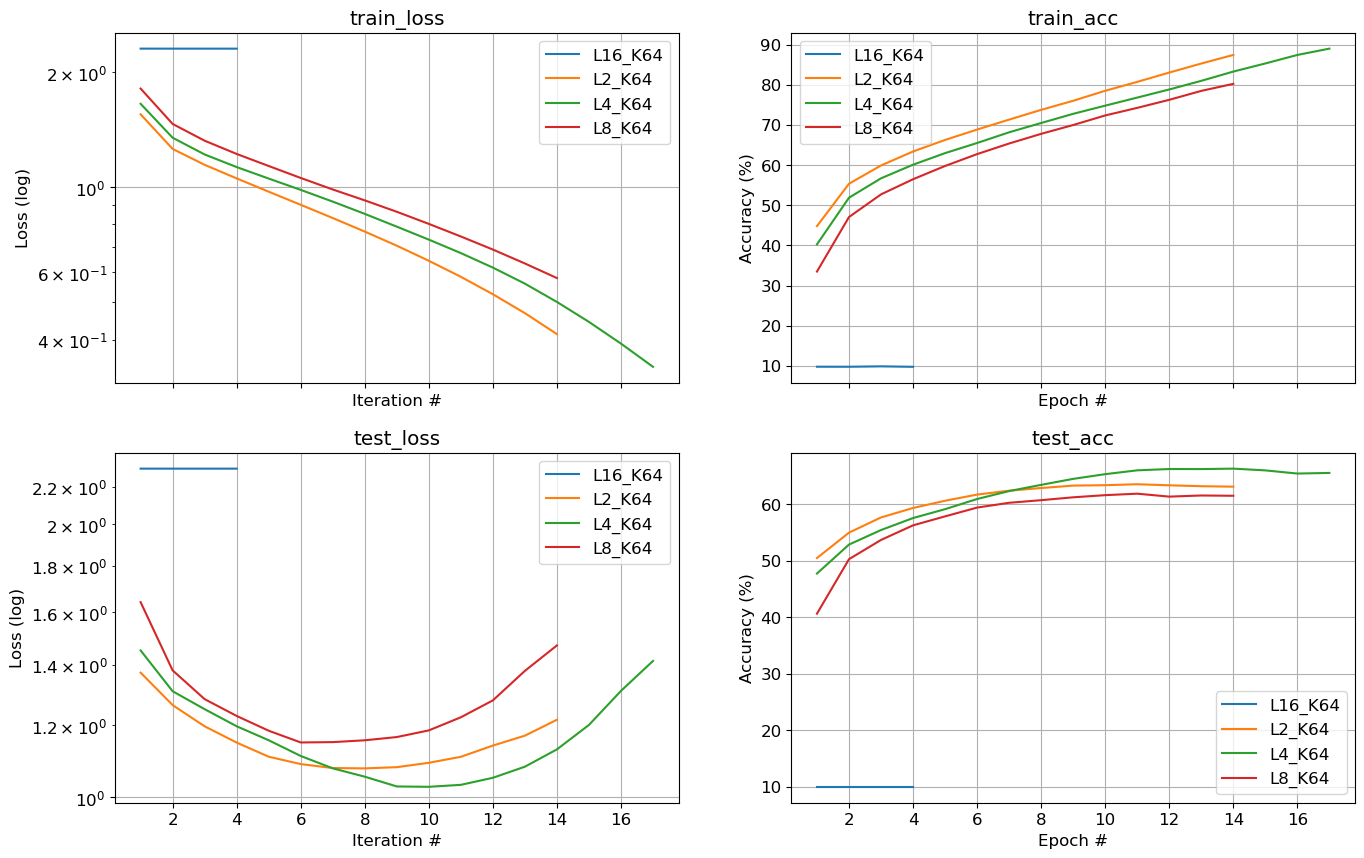

In [8]:
plot_exp_results('exp1_1_L*_K64*.json')

#### Experiment 1.2: Varying the number of filters per layer (`K`)

Now we'll test the effect of the number of convolutional filters in each layer.

**Configuratons**:
- `L=2` fixed, with `K=[32],[64],[128]` varying per run.
- `L=4` fixed, with `K=[32],[64],[128]` varying per run.
- `L=8` fixed, with `K=[32],[64],[128]` varying per run.

So 9 different runs in total. To clarify, each run `K` takes the value of a list with a single element.

**Naming runs**:
Each run should be named `exp1_2_L{}_K{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_2_L2_K32`. 

**TODO**: Run the experiment on the above configuration with the `CNN` model. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_2', 'out_dir': '/home/galkesten/CS236781/Homework2/results', 'seed': 42, 'device': None, 'bs_train': 32, 'bs_test': 32, 'batches': 1500, 'epochs': 30, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.0001, 'reg': 0.0001, 'pool_every': 4, 'hidden_dims': [128], 'model_type': 'cnn', 'conv_params': {'kernel_size': 3, 'stride': 1, 'padding': 1}, 'activation_type': 'relu', 'activation_params': {}, 'pooling_type': 'max', 'pooling_params': {'kernel_size': 2}, 'batchnorm': False, 'dropout': 0.0, 'bottleneck': False, 'kw': {}}


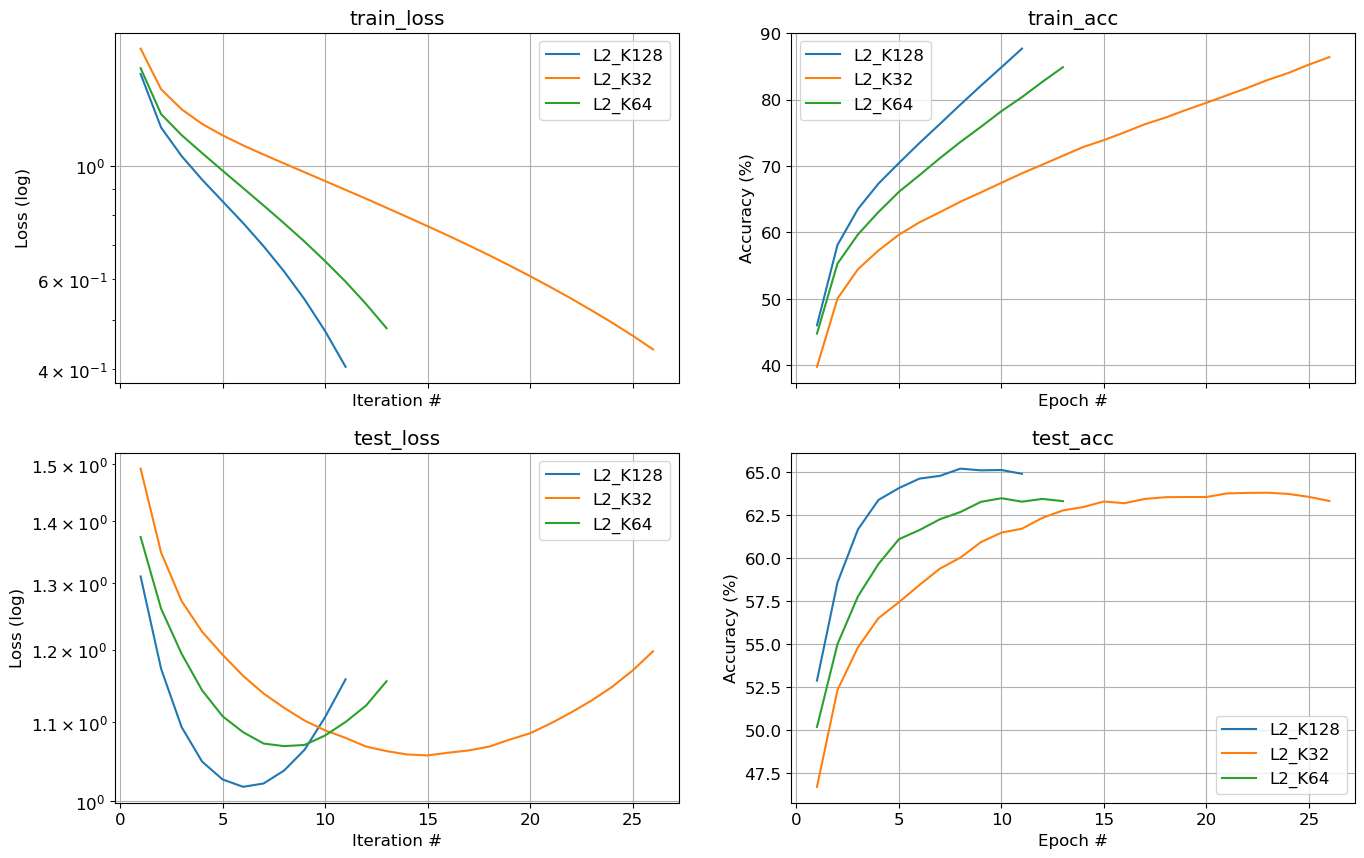

In [9]:
plot_exp_results('exp1_2_L2*.json')

common config:  {'run_name': 'exp1_2', 'out_dir': '/home/galkesten/CS236781/Homework2/results', 'seed': 42, 'device': None, 'bs_train': 32, 'bs_test': 32, 'batches': 1500, 'epochs': 30, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.0001, 'reg': 0.0001, 'pool_every': 4, 'hidden_dims': [128], 'model_type': 'cnn', 'conv_params': {'kernel_size': 3, 'stride': 1, 'padding': 1}, 'activation_type': 'relu', 'activation_params': {}, 'pooling_type': 'max', 'pooling_params': {'kernel_size': 2}, 'batchnorm': False, 'dropout': 0.0, 'bottleneck': False, 'kw': {}}


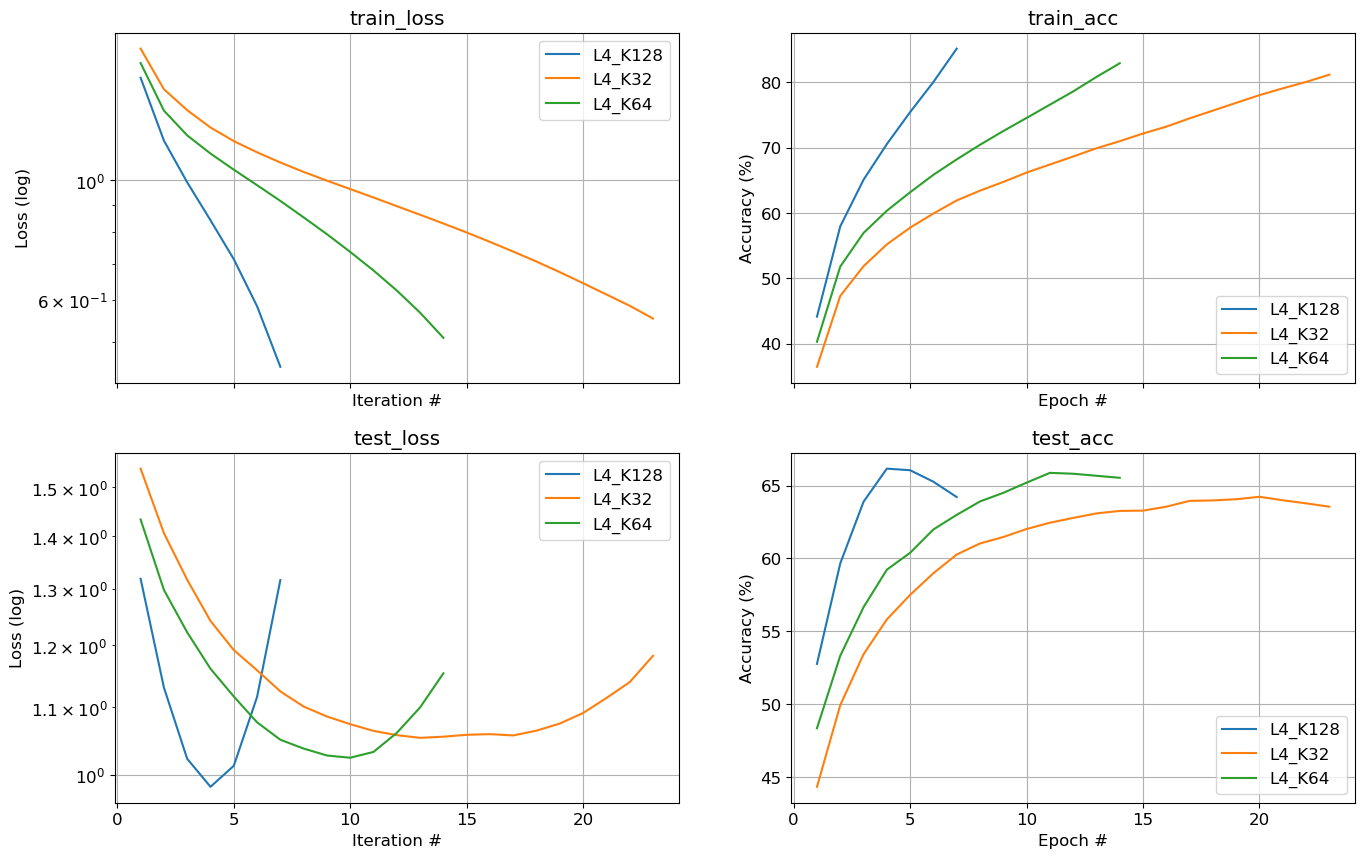

In [10]:
plot_exp_results('exp1_2_L4*.json')

common config:  {'run_name': 'exp1_2', 'out_dir': '/home/galkesten/CS236781/Homework2/results', 'seed': 42, 'device': None, 'bs_train': 32, 'bs_test': 32, 'batches': 1500, 'epochs': 30, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.0001, 'reg': 0.0001, 'pool_every': 4, 'hidden_dims': [128], 'model_type': 'cnn', 'conv_params': {'kernel_size': 3, 'stride': 1, 'padding': 1}, 'activation_type': 'relu', 'activation_params': {}, 'pooling_type': 'max', 'pooling_params': {'kernel_size': 2}, 'batchnorm': False, 'dropout': 0.0, 'bottleneck': False, 'kw': {}}


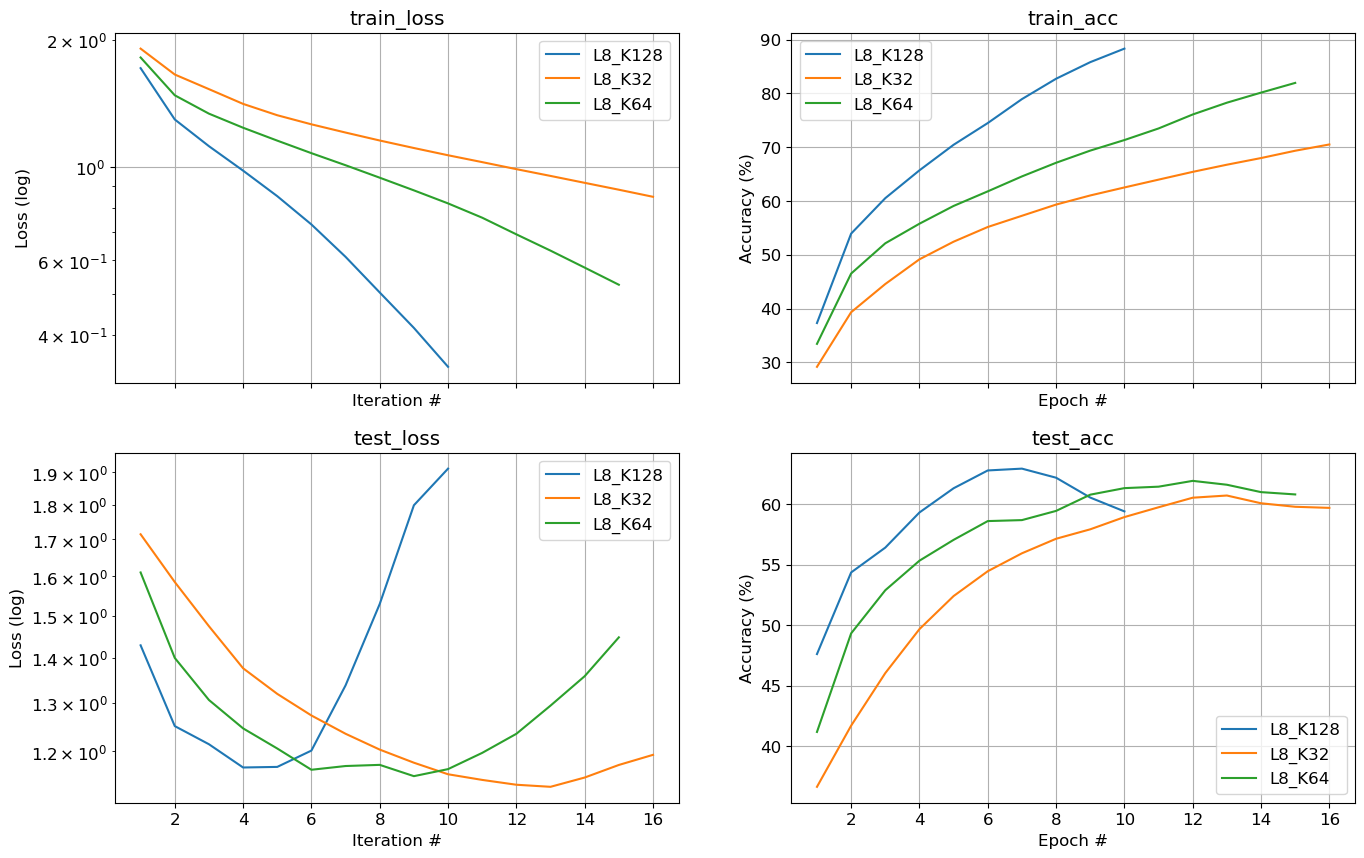

In [11]:
plot_exp_results('exp1_2_L8*.json')

#### Experiment 1.3: Varying both the number of filters (`K`) and network depth (`L`)

Now we'll test the effect of the number of convolutional filters in each layer.

**Configuratons**:
- `K=[64, 128]` fixed with `L=2,3,4` varying per run.

So 3 different runs in total. To clarify, each run `K` takes the value of an array with a two elements.

**Naming runs**:
Each run should be named `exp1_3_L{}_K{}-{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_3_L2_K64-128`. 

**TODO**: Run the experiment on the above configuration  with the `CNN` model. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_3', 'out_dir': '/home/galkesten/CS236781/Homework2/results', 'seed': 42, 'device': None, 'bs_train': 32, 'bs_test': 32, 'batches': 1500, 'epochs': 30, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.0001, 'reg': 0.0001, 'pool_every': 4, 'hidden_dims': [128], 'model_type': 'cnn', 'conv_params': {'kernel_size': 3, 'stride': 1, 'padding': 1}, 'activation_type': 'relu', 'activation_params': {}, 'pooling_type': 'max', 'pooling_params': {'kernel_size': 2}, 'batchnorm': False, 'dropout': 0.0, 'bottleneck': False, 'kw': {}}


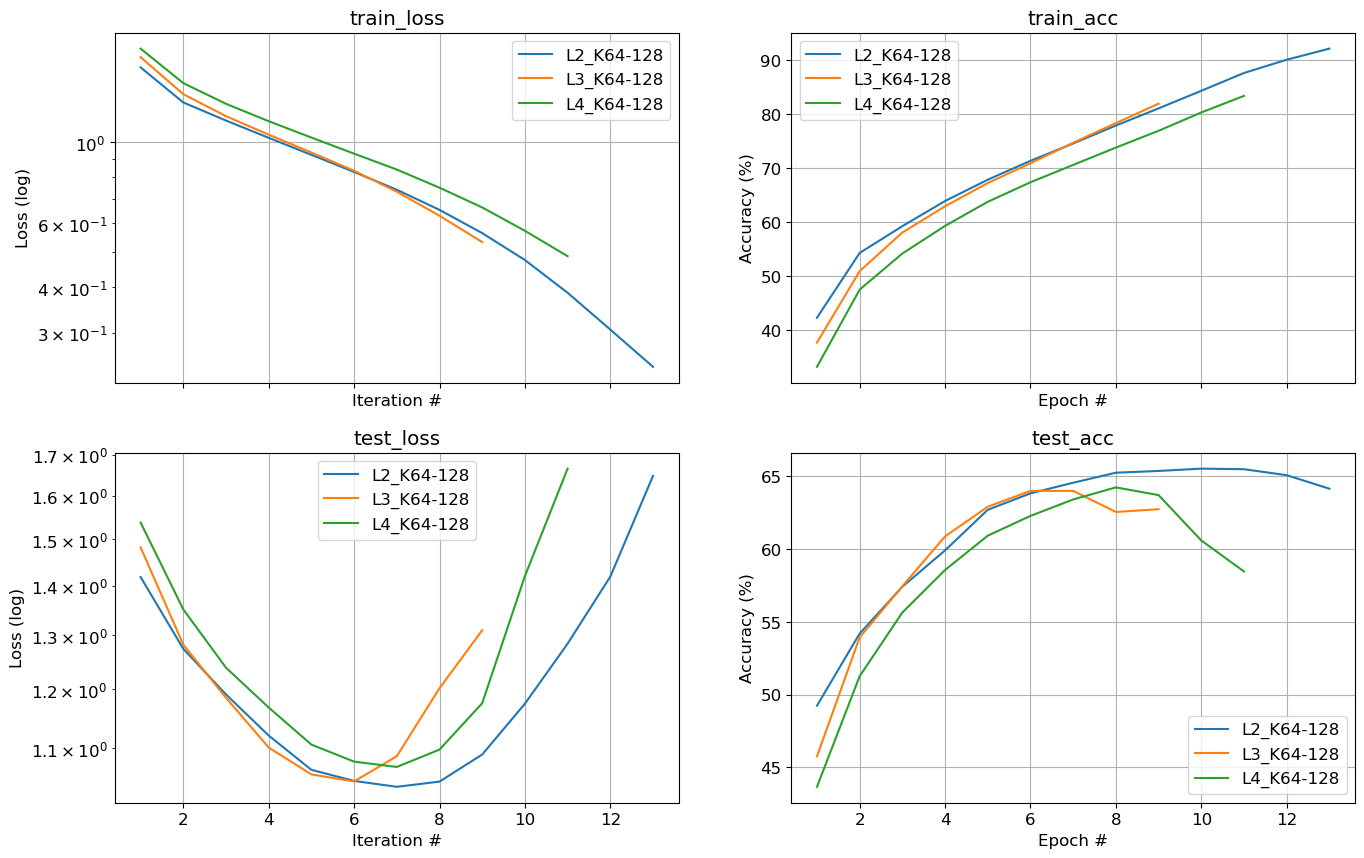

In [12]:
plot_exp_results('exp1_3*.json')

#### Experiment 1.4: Adding depth with Residual Networks

Now we'll test the effect of skip connections on the training and performance.

**Configuratons**:
- `K=[32]` fixed with `L=8,16,32` varying per run.
- `K=[64, 128, 256]` fixed with `L=2,4,8` varying per run.

So 6 different runs in total.

**Naming runs**:
Each run should be named `exp1_4_L{}_K{}-{}-{}` where the braces are placeholders for the values.

**TODO**: Run the experiment on the above configuration with the `ResNet` model. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_4', 'out_dir': '/home/galkesten/CS236781/Homework2/results', 'seed': 42, 'device': None, 'bs_train': 32, 'bs_test': 32, 'batches': 1500, 'epochs': 60, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.0001, 'reg': 0.0001, 'pool_every': 8, 'hidden_dims': [512, 256], 'model_type': 'resnet', 'conv_params': {'kernel_size': 3, 'stride': 1, 'padding': 1}, 'activation_type': 'relu', 'activation_params': {}, 'pooling_type': 'max', 'pooling_params': {'kernel_size': 2}, 'batchnorm': True, 'dropout': 0.2, 'bottleneck': False, 'kw': {}}


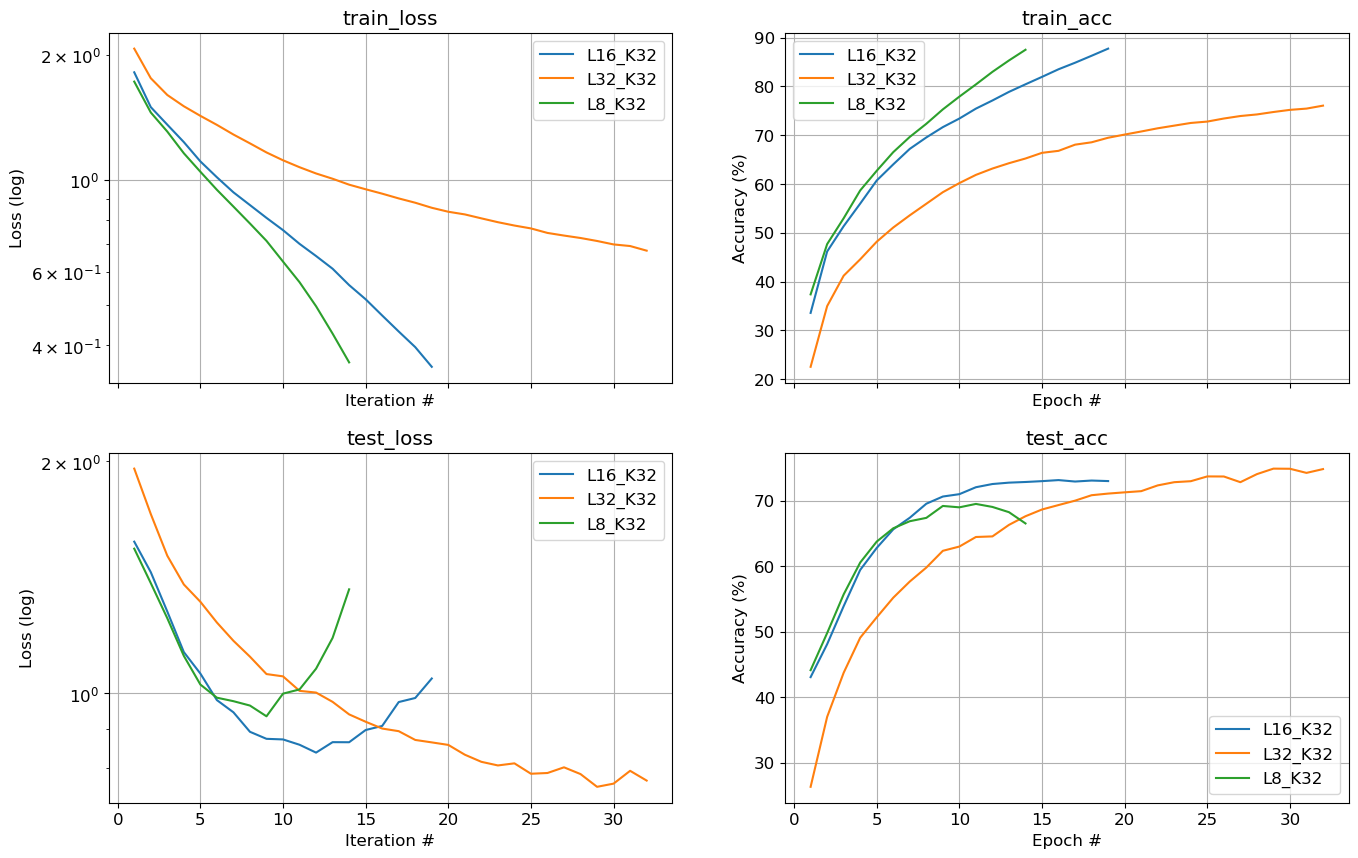

In [13]:
plot_exp_results('exp1_4_L*_K32.json')

common config:  {'run_name': 'exp1_4', 'out_dir': '/home/galkesten/CS236781/Homework2/results', 'seed': 42, 'device': None, 'bs_train': 32, 'bs_test': 32, 'batches': 1500, 'epochs': 60, 'early_stopping': 3, 'checkpoints': None, 'lr': 0.0001, 'reg': 0.0001, 'pool_every': 8, 'hidden_dims': [512, 256], 'model_type': 'resnet', 'conv_params': {'kernel_size': 3, 'stride': 1, 'padding': 1}, 'activation_type': 'relu', 'activation_params': {}, 'pooling_type': 'max', 'pooling_params': {'kernel_size': 2}, 'batchnorm': True, 'dropout': 0.2, 'bottleneck': False, 'kw': {}}


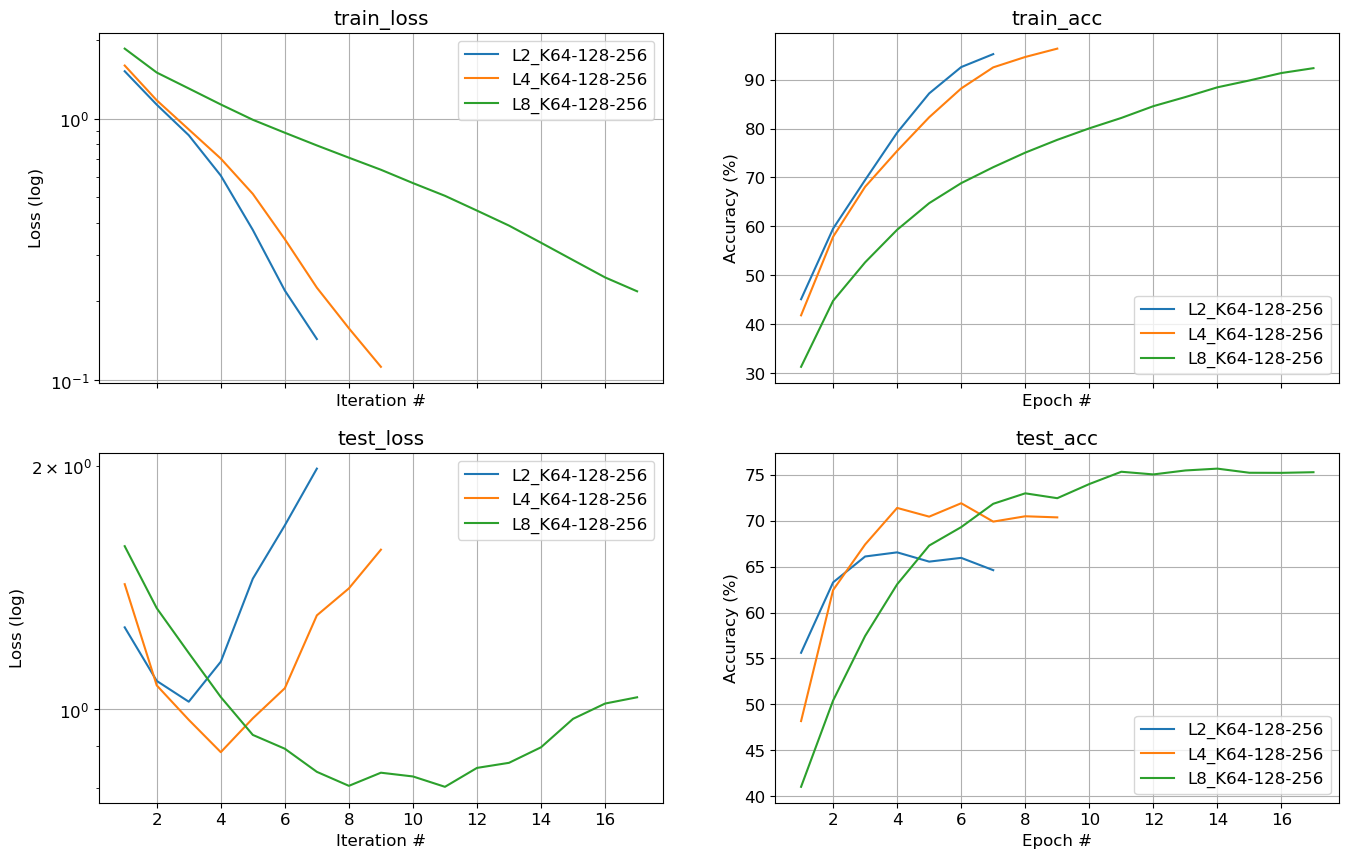

In [14]:
plot_exp_results('exp1_4_L*_K64*.json')

## Questions
<a id=part5_4></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw2/answers.py`.

In [15]:
from cs236781.answers import display_answer
import hw2.answers

### Question 1 

Analyze your results from experiment 1.1. In particular,
1.  Explain the effect of depth on the accuracy. What depth produces the best results and why do you think that's the case?
1. Were there values of `L` for which the network wasn't trainable? what causes this? Suggest two things which may be done to resolve it at least partially.

In [16]:
display_answer(hw2.answers.part5_q1)


**Your answer:**
In this experiment, we used the Adam optimizer, max pooling every 4 layers, a learning rate of 0.0001 and regularization
0.0001. batch size 32, early stopping=3. This is also the hyperparameters that was chosen for experiments 1.2,1.3.
The results of Experiment 1.1 show that the depth of the network impacts accuracy.
The L16 configurations (16 layers per block) with both 32 and 64 filters per layer were non-trainable, 
with test accuracy stagnant at 10%. This is likely due to vanishing gradients and overfitting, where the
network struggles
 to learn effectively. The L8 configurations (8 layers per block) showed better performance, with L8_K32
 reaching approximately 60.18%
test accuracy and L8_K64 reaching around 61.47%. Although these results were better than L16, 
they were not the best observed.

The L4 configurations produced the best results. The L4_K32 configuration achieved a
test accuracy of about 63.99%, while L4_K64 reached around 65.51%. This works better compared to L2 and L8.
 The L2 configurations also performed well, particularly with more filters. 
 The L2_K32 configuration achieved about 63.68% test accuracy, and L2_K64 reached around 63.08%.
 We also believe that max pooling on the fourth layer helped in enhancing the results of L4 compared to L2 configuration.

In choosing hyperparameters, we focused on ensuring convergence and avoiding vanishing gradients. 
We manually tuned various hyperparameters, including learning rate and regularization. 
A very small learning rate (0.0001) was necessary for the L8 configurations to ensure stable learning and convergence. 
We also had to use small regularization values, as larger ones would encourage
smaller weights and exacerbate the vanishing gradient problem. This 
 led to observable overfitting, as seen in the training and testing loss graphs, 
 but was necessary to prevent the gradients from vanishing entirely and to allow 
 the deeper network to learn. Despite the extensive tuning, the highest accuracy achieved
 was around 65%, indicating room for improvement. 

To address the vanishing gradients problem in very deep networks,we can use 
batch normalization which stabilize the learning process by normalizing the inputs of each layer.
Additionally, adding residual connections (as in ResNet architectures) can provide shortcut paths for gradients, 
allowing for more effective training of deep networks. 
These strategies can mitigate the problems associated with training very deep networks and improve their performance.
T



### Question 2 

Analyze your results from experiment 1.2. In particular, compare to the results of experiment 1.1.

In [17]:
display_answer(hw2.answers.part5_q2)


The results of Experiment 1.2 provide further insights into the effect of varying the number of filters per layer (K)
 in combination with different network depths (L).
 For the L2 configurations, we observed a slight improvement in test accuracy as `K` increased, 
 Despite using early stopping, the `L2_K128` configuration converged too 
 quickly, necessitating stopping after less than 10 epochs. We were unable to use a changing learning rate to control 
 convergence effectively. 
 This shows that for shallow network, bigger amount of feature maps has  
 the possibility to improve accuracy if we control overfitting.
 The `L4` configurations showed similar trends to `L2`, with `K=128` leading to overfitting 
 and `K=64` yielding the best performance. For the `L8` configurations, we observed similar results but 
 with performance being less good than the `L4` and `L2` configurations. 

Comparing these results to Experiment 1.1, we again see that the performance for `L8` is less favorable than the 
other depths, likely due to the vanishing gradients problem. The `L4` configuration with `K=64` achieved the best 
performance, consistent with previous findings.
 Across both experiments, overfitting remains a significant issue that we struggled to control, 
caused by the need to choose hyper parameters that will allow L8 configuration to converge.


### Question 3 

Analyze your results from experiment 1.3.

In [18]:
display_answer(hw2.answers.part5_q3)


**Your answer:**
Experiment 1.3 explored varying both the number of filters and the network depth. 
The L2 configuration with layers [64, 64, 128, 128] achieved the highest test accuracy of approximately 65.54%. 
The L3 configuration with layers [64, 64, 64, 128, 128, 128] showed a lower peak test accuracy (64.01%). 
There is probably an influence of vanishing gradients phenomena also with 6 depth network.
The L4 configuration with layers [64, 64, 64, 64, 128, 128, 128, 128] exhibited the most significant overfitting, 
achieving a peak accuracy of around 64.25% before declining. 

Again, we see that the performance of 8 depth layer has a decrease in performance, despite the fact we expect it to learn
better with the ability to learn hierarchical features.
Additionally, we do not see significant improvement by employing the 64-128 configuration 
compared to four layers of 64 as before. 
We also observe that incorporating  128 filters led to quicker overfitting,
necessitating early stopping to prevent excessive epochs, consistent with the behavior observed previously.



### Question 4

Analyze your results from experiment 1.4. Compare to experiment 1.1 and 1.3.

In [19]:
display_answer(hw2.answers.part5_q4)


In Experiment 1.4, we explored the impact of skip connections (Residual Networks) on training and performance. 
We tuned the hyperparameters manually, using the same learning rate, 
weight decay, and Adam optimizer as before. 
However, we used max pooling every 8 layers in these experiments to allow effective learning
in deeper networks (we had to choose the same hyperparameters for all network configurations).
Additionally, dropout of 0.2 and batch normalization were incorporated to help manage overfitting.

The L8_K32 configuration reached a test accuracy of approximately 69.19%. 
The model converged well but began to overfit after 10 epochs, as indicated by the rising test loss. 
The training accuracy continued to increase steadily, suggesting that the model was learning effectively 
but entered overfitting due to the small filter size and increased depth.

The `L16_K32` configuration achieved a higher test accuracy of around 72.99%,
indicating that adding more layers improved the model's capacity to learn complex features. 
However, overfitting was still a concern as the test loss increased after about 12 epochs.
The training accuracy was high, with early stopping helping to prevent excessive overfitting.
The`L32_K32 configuration achieved the highest test accuracy in this set, reaching around 74.82%. 
Despite the increased depth, the model benefitted from skip connections, 
which mitigated some of the vanishing gradient issues. The training loss decreased consistently, 
and the accuracy improved steadily, indicating effective learning. 
We were also able to train the network for a longer time before early
stopping compared to other configurations in this experiment.

In the K=[64, 128, 256] configurations, the L2_K64-128-256 configuration achieved a test accuracy of 
approximately 66.56%. The model learned quickly but showed significant overfitting
due to the high filter sizes and shallow depth (6 layers). 
The training accuracy increased rapidly, suggesting the model had enough capacity to learn complex patterns,
but the generalization was poor. The `L4_K64-128-256` configuration performed better, achieving
a test accuracy of around 71.91%. The increased depth helped improve generalization,
though overfitting remained a challenge. The model showed a steady increase in training accuracy,
with early stopping helping to control overfitting. The `L8_K64-128-256` configuration achieved the highest
test accuracy in this set, reaching around 75.68%. The deeper network benefitted significantly from the residual
connections, which helped mitigate vanishing gradients and improved learning.
The model showed the best training performance, with high training accuracy and a more controlled overfitting pattern.

Overall, we observed several key points from both sets of experiments:
1. **Skip Connections**: The skip connections allowed us to train deeper networks compared to previous experiments.
We were able to train networks with depths of 8, 16, and 32 layers without encountering vanishing gradient problems.
Compared to previous experiments without skip connections, the use of residual networks significantly improved the
performance of deeper models.
2. **Depth**: Deeper networks performed best in both sets of experiments. 
This is likely due to their ability to learn hierarchical features, combined with max pooling every 8 layers,
which gradually increased the receptive field. The deeper networks also generalized better compared to the
shallow networks and networks from previous experiments.
3. **Increased Filter Sizes**: The increased filter sizes (`K=64-128-256` configuration) helped 
achieve slightly better results compared to the `L32_K32` configuration. However, this configuration is
suitable only for deeper networks, as observed. In shallow networks, we reached overfitting quite quickly,
similar to the behavior in Experiment 1.3.
4. **Hyperparameter Tuning**: We believe that with appropriate hyperparameter tuning for the deeper networks,
we can achieve even better results.

